### Group 8
- Nimrod Grandpierre
- Jonas Riber Jørgensen
- Johan Ulstrup
- Laura Fur

# Project 3: Multiple Alignment
This project is about implementing the exact (dynamic programming based) and the 2-approximation algorithm for global sum-of-pairs multiple alignment.
The first part of the project is to implement two programs: sp_exact_3 that implements the exact algorithm for computing an optimal MSseq1 of 3 sequences and its score (decribed on page 408 in [Ohlebusch], or in Section 14.6.1 in [Gusfield]), and sp_approx that implements the 2-approximation algorithm for any number of sequences (described in Section 8.2.2 in [Ohlebusch], or in Section 14.6.2 in [Gusfield]).

For both programs, the objective is to minimize the SP-score using the below score matrix and a gap penalty of 5.

|    | A | C | G | T |
|----|---|---|---|---|
| A  | 0 | 5 | 2 | 5 |
| C  | 5 | 0 | 5 | 2 |
| G  | 2 | 5 | 0 | 5 |
| T  | 5 | 2 | 5 | 0 |

The second part of the project is to use your MSA programs (or any other MSA programs) to align the 8 sequences of length 200 in brca1-testseqs.fasta as close to optimum as possible (the sequences corresponds to first 200 nucleotides in the mRNA from the BRCA1 gene in cow, wolf, chicken, human, macaque, mouse, chimpanzee, and rat).

## <span style='color:cornflowerblue'>Methods<span/>


>An overview of the implemented programs ```sp_exact_3``` and ```sp_approx```. Comment on design/implementation choices that differ significantly from what we have talked about in class. Be precise in describing how to access and use your programs. Also explain how you have verified the correctness of your programs. The files testdata_short.txt and ```testdata_long.txt``` each contain three sequences and the score of their alignment as computed by my implementation ```sp_exact_3```. You are welcome to use this as (part of) your test data. 

##### **Sum-of-pairs exact algorithm**

```sp_exact_3``` runs on three sequences only. The input file can have more than three sequences but will only use the first three. First, a dynamic programming matrix for the alignment is initialized with linear gap cost. 

 

For three sequences, in order to compute a current cell, ```(i,j)```, seven previous cells must be considered. From these, we can have three different cases: 

**<span style="color:lightskyblue">Case 1</span>**: **all** three sequences are matched at this position.  

- Sum the cost from the score matrix for every nucleotide combination. 

**<span style="color:lightskyblue">Case 2</span>**: **two** of the sequences are matched and aligns with a ```'-'``` in the third sequence at this position.  
-  Match/mismatch score for the matched sequences is added with 2 x gap-cost for the other two combinations that do not match. The gap can be in either of the three sequences, so for this particular case, there are three possible combinations. 

**<span style="color:lightskyblue">Case 3</span>**: **one** sequence aligns with a ```'-'``` in the other two sequences at this position.  

-  No match/mismatch score. Only 2 x gap-costs, since the case where a ```'-'``` in one sequence is aligned with a ```'-'``` in another sequence is not considered.  Again, three possible combinations can lead to this outcome.

The minimum value between these conditions is chosen for the current cell. Backtracking takes a column-based approach. The score of the current cell is compared to the seven previous cells to which it came from. This inserts the corresponding index of the sequence or gap into the alignment. 
This creates a nested list, in which an internal list is a symbol for each of the three sequences at the given positions, thus representing columns in the alignment.

**To validate the algorithms correctness it was on the** ```testdata_short.txt``` **and** ```testdata_long.txt``` **where the correct exact optimal score is indicated. The algorithm results in the same scores: 198 and 1482, respectively.**

## <span style='color:cornflowerblue'>Implementations<span/>


In [1]:
import itertools
from extend_msa import msa
from nw import nw
from read_fasta import read_fasta
import os
import pandas as pd
import matplotlib.pyplot as plt

### **Parameters**

In [2]:
scoreMatrix = {
    'A': {'A': 0, 'C': 5, 'G': 2, 'T': 5, '-': 5, 'N': 5, 'R': 5, 'S': 5},
    'C': {'A': 5, 'C': 0, 'G': 5, 'T': 2, '-': 5, 'N': 5, 'R': 5, 'S': 5},
    'G': {'A': 2, 'C': 5, 'G': 0, 'T': 5, '-': 5, 'N': 5, 'R': 5, 'S': 5},
    'T': {'A': 5, 'C': 2, 'G': 5, 'T': 0, '-': 5, 'N': 5, 'R': 5, 'S': 5},
    '-': {'A': 5, 'C': 5, 'G': 5, 'T': 5, '-': 0, 'N': 5, 'R': 5, 'S': 5},
    'N': {'A': 5, 'C': 5, 'G': 5, 'T': 5, '-': 5, 'N': 5, 'R': 5, 'S': 5},
    'R': {'A': 5, 'C': 5, 'G': 5, 'T': 5, '-': 5, 'N': 5, 'R': 5, 'S': 5},
    'S': {'A': 5, 'C': 5, 'G': 5, 'T': 5, '-': 5, 'N': 5, 'R': 5, 'S': 5}
}

gapCost = 5

### **Function for printing algorithm outputs**

In [3]:
def pretty(sequences: dict, output):
    if len(output) == 4: # 2-Approximation algorithm
        print(f'\033[1mCenter string:\033[0m {output[2]}\n')
        sequences = output[3]
    for i, obj in enumerate(sequences):
        print(f'>{obj}\n{output[0][i]}')
    print(f'\n\033[1mOptimal sum-of-pairs score:\033[0m {output[1]}')
    return 

### **2-approximation algorithm**

In [4]:
def sp_approx(sequences: dict, score_matrix: dict, gap_cost: int) -> list[list]:

    """ Part 1: Initializing the MSA """
    seq_names = list(sequences.keys())
    alignments = {}
    seqAligned_order = []

    """ a) Finding center sequence from distance matrix and average distances """
    # Distance matrix
    distanceMatrix = [[0] * len(seq_names) for _ in range(len(seq_names))]

    for i, seq_i in enumerate(seq_names):
        for j, seq_j in enumerate(seq_names):
            seqA = sequences[seq_i]
            seqB = sequences[seq_j]

            alignment = nw(seqA, seqB, score_matrix, gap_cost)
            distanceMatrix[i][j] = alignment[2] # the distance is in the 2nd position in the ouput from NW()

            # Saving the full output from nw() for later
            if seq_i != seq_j and i < j:
                alignments[(seq_i, seq_j)] = alignment

    # Average distance from sequences to all other sequences
    avgDist = {}

    for i, seq_name in enumerate(seq_names):
        avg_distance = sum(distanceMatrix[i]) / len(distanceMatrix[i])
        avgDist[seq_name] = round(avg_distance, 2)

    ## Getting the center sequence - i.e., the sequence that is, on average, most similar to all other sequences
    centerSeq_name = min(avgDist, key = avgDist.get)

    """ b) Initializing alignment with the most similar sequences, with the center sequence in the first row """

    # Finding the first pair of sequences in the alignment - i.e., the sequences that are most similar
    firstPair_name = min(alignments, key = lambda k: alignments[k][2])

    M = []

    if firstPair_name[0] == centerSeq_name: # Case: the center sequence is the FIRST sequence in the pair-tuple
        M.append(alignments[firstPair_name][0])
        M.append(alignments[firstPair_name][1])
        seqAligned_order.extend([firstPair_name[0], firstPair_name[1]])

    else: # Case: the center sequence is the SECOND sequence in the pair-tuple
        M.append(alignments[firstPair_name][1])
        M.append(alignments[firstPair_name][0])
        seqAligned_order.extend([firstPair_name[1], firstPair_name[0]])

    M = list(map(list, zip(*M))) # creating list of columns

    """ Part 2: Computing the multiple sequence alignment using the 2-approximation algorithm, given in the extend_msa.py file """
    
    MA = []

    for i in alignments:
        A = []
        if i != firstPair_name and centerSeq_name in i: # Only looking at pairs that are not the first pair (which we already have) and sequences aligned with the center sequence
            if i[0] == centerSeq_name: # Case: the center sequence is the FIRST sequence in the pair-tuple
                A.append(alignments[i][0])
                A.append(alignments[i][1])
                seqAligned_order.append(i[1])
            
            else: # Case: the center sequence is the SECOND sequence in the pair-tuple
                A.append(alignments[i][1])
                A.append(alignments[i][0])
                seqAligned_order.append(i[0])

            A = list(map(list, zip(*A))) # Creating list of columns
            MA = msa(M, A)

    MSA = ([''.join(column) for column in zip(*MA)])

    """ Part 3: Getting the SP score from the sum of columns """

    SP_score = []
    
    for i in MA:
        combs = list(itertools.combinations(i, 2))
        for pair in combs:
            score = score_matrix[pair[0]][pair[1]]
            SP_score.append(score)

    return MSA, sum(SP_score), centerSeq_name, seqAligned_order

### **Exact algorithm for three sequences**

In [5]:
def sp_exact_3(sequences: dict, score_matrix: dict, gap_cost: int, hide_alignments = False):
    
    seq1, seq2, seq3 = list(sequences.values())
    n, m, l = len(seq1), len(seq2), len(seq3)

    """ Part 1: Initialization of dynamic programming table """

    dp = [[[float('inf')] * (l + 1) for _ in range(m + 1)] for _ in range(n + 1)]

    dp[0][0][0] = 0

    for i in range(1, n+1):
        dp[i][0][0] = dp[i-1][0][0] + gap_cost
    for j in range(1, m+1):
        dp[0][j][0] = dp[0][j-1][0] + gap_cost
    for k in range(1, l+1):
        dp[0][0][k] = dp[0][0][k-1] + gap_cost 

    """ Part 2: Filling the dynamic programming table """

    for i in range(0, n+1):
        for j in range(0, m+1):
            for k in range(0, l+1):
                v0, v1, v2, v3, v4, v5, v6, v7 = [float('inf')] * 8
                
                if i == 0 and j == 0 and k == 0: 
                    v0 = 0
                
                if i > 0 and j > 0 and k > 0:                 
                    v1 = dp[i-1][j-1][k-1] + score_matrix[seq1[i-1]][seq2[j-1]] + score_matrix[seq1[i-1]][seq3[k-1]] + score_matrix[seq2[j-1]][seq3[k-1]]

                if i > 0 and j > 0 and k >= 0:                
                    v2 = dp[i-1][j-1][k] + score_matrix[seq1[i-1]][seq2[j-1]] + gap_cost + gap_cost

                if i > 0 and j >= 0 and k > 0:                
                    v3 = dp[i-1][j][k-1] + score_matrix[seq1[i-1]][seq3[k-1]] + gap_cost + gap_cost

                if i >= 0 and j > 0 and k > 0:                
                    v4 = dp[i][j-1][k-1] + score_matrix[seq2[j-1]][seq3[k-1]] + gap_cost + gap_cost

                if i > 0 and j >= 0 and k >= 0:              
                    v5 = dp[i-1][j][k] + gap_cost + gap_cost

                if i >= 0 and j > 0 and k >=0:               
                    v6 = dp[i][j-1][k] + gap_cost + gap_cost

                if i >= 0 and j >= 0 and k > 0:               
                    v7 = dp[i][j][k-1] + gap_cost + gap_cost
                
                dp[i][j][k] = min(v0, v1, v2, v3, v4, v5, v6, v7)

    # return last cell or continue with backtracking
    score = dp[n][m][l]

    """ Part 3: Backtracking (optional) """
    # Backtracking 
    def backtracking(seq1, seq2, seq3, dp, score_matrix, gap_cost):

        alignment = []
        i, j, k = n, m, l

        while i > 0 or j > 0 or k > 0:
            # Case 1: all sequences match
            if i > 0 and j > 0 and k > 0 and dp[i][j][k] == dp[i-1][j-1][k-1] + score_matrix[seq1[i-1]][seq2[j-1]] + score_matrix[seq1[i-1]][seq3[k-1]] + score_matrix[seq2[j-1]][seq3[k-1]]:
                alignment.append([seq1[i-1], seq2[j-1], seq3[k-1]])
                i -= 1
                j -= 1
                k -= 1

            # Case 2: two sequences match, three different combinations (gap in either of the three sequences)
            elif i > 0 and j > 0 and dp[i][j][k] == dp[i-1][j-1][k] + score_matrix[seq1[i-1]][seq2[j-1]] + gap_cost + gap_cost:
                alignment.append([seq1[i-1], seq2[j-1], '-'])
                i -= 1
                j -= 1

            elif i > 0 and k > 0 and dp[i][j][k] == dp[i-1][j][k-1] + score_matrix[seq1[i-1]][seq3[k-1]] + gap_cost + gap_cost:
                alignment.append([seq1[i-1], '-', seq3[k-1]])
                i -= 1
                k -= 1
            elif j > 0 and k > 0 and dp[i][j][k] == dp[i][j-1][k-1] + score_matrix[seq2[j-1]][seq3[k-1]] + gap_cost + gap_cost:
                alignment.append(['-', seq2[j-1], seq3[k-1]])
                j -= 1
                k -= 1

            # Case 3: no matches, three combinations (letter in either of the three sequences)
            elif i > 0 and dp[i][j][k] == dp[i-1][j][k] + gap_cost + gap_cost:
                alignment.append([seq1[i-1], '-', '-'])
                i -= 1
            elif j > 0 and dp[i][j][k] == dp[i][j-1][k] + gap_cost + gap_cost:
                alignment.append(['-', seq2[j-1], '-'])
                j -= 1
            elif k > 0 and dp[i][j][k] == dp[i][j][k-1] + gap_cost + gap_cost:
                alignment.append(['-', '-', seq3[k-1]])
                k -= 1

        return alignment[::-1]

    alignment_cols = backtracking(seq1, seq2, seq3, dp, score_matrix, gap_cost)
    alignment_rows = [[],[],[]]
    
    for a, b, c in alignment_cols: # Getting letters from each column and insert as rows.
        alignment_rows[0].append(a)
        alignment_rows[1].append(b)
        alignment_rows[2].append(c)

    joined_strings = [''.join(alignment) for alignment in alignment_rows]

    if hide_alignments == True:
        return score
    else:
        return [joined_strings, score]

## <span style='color:cornflowerblue'>Tests<span/>

In [6]:
testdata_short = read_fasta('testdata_short.txt')
testdata_long = read_fasta('testdata_long.txt')

### **2-approximation algorithm**

In [7]:
pretty(testdata_short, sp_approx(testdata_short, scoreMatrix, gapCost))

Center string: seq3

>seq3
-TGCATGCTGAAA--CTT-C-TCAA-C-CA
>seq2
ATGGAT-TT-AT---CTG-C-TCT--T-CG
>seq1
--GT-T-CCGAAAGGCTAGCGCTAGGCGCC

Optimal sum-of-pairs score: 208


### **Exact algorithm**

In [8]:
pretty(testdata_short, sp_exact_3(testdata_short, scoreMatrix, gapCost, hide_alignments = False))

>seq1
GTTCCGAAAGGCTAGCGCTAGGC-GCC-
>seq2
A-T--G-GAT-TT-AT-CTGCTC-TTCG
>seq3
--T--G-CATGCTGAAACTTCTCAACCA

Optimal sum-of-pairs score: 198


## <span style='color:cornflowerblue'>Experiments<span/>
Splitting of files for Question 1 and 2 was done in the command line using the following command:

awk '/^>/ {if(++n > ```n_seqs```) exit;} {print;}' ```infile.fasta``` > ```outfile.fasta```

### **Question 1**
>What is the score of an optimal aligment of the first 3 sequences in brca1-testseqs.fasta (i.e. brca1_bos_taurus, brca1_canis_lupus and brca1_gallus_gallus) as computed by your program sp_exact_3? How does an optimal alignment look like?

In [9]:
brca1_testseqs_3 = read_fasta('brca1-testseqs-3.fasta')
pretty(brca1_testseqs_3, sp_exact_3(brca1_testseqs_3, scoreMatrix, gapCost, hide_alignments = False))

>brca1_bos_taurus
ATGGATTTATCTGCGGATCATGTTGAAGAAGTACAAAATGTCCTCAATGCTATGCA-GAAAATCTTAG--AGTGTCCAAT-ATGTCTGGAGTTGATCAAAGAG-CCT-GTCTCTACAAAGTGTGA-CCA-CA-TATTTTGCAAATTTTG-TATGCTGAA-AC-TTCTCAACCA-GAAGAAAGGGCCTTCACAATGTCC--TTTGTGTAAGAATGA-
>brca1_canis_lupus
ATGGATTTATCTGCGGATCGTGTTGAAGAAGTACAAAATGTTCTTAATGCTATGCA-GAAAATCTTAG--AGTGTCCAAT-ATGTCTGGAGTTGATCAAAGAG-CCT-GTTTCTACAAAGTGTGA-TCA-CA-TATTTTGCAAATTTTG-TATGCTGAA-AC-TTCTCAACCA-GAGGAAGGGGCCTTCACAGTGTCC--TTTGTGTAAGAACGA-
>brca1_gallus_gallus
GCGAA---ATGTA-ACA-CG-GTAGAGGTGAT-CGGGGTG-CGTT-ATAC-GTGCGTGGTGACCTCGGTCGGTGT-TGACGGTGCCTGGGGTTCCTCAGAGTGTTTTGGGGTCTGAAGGATG-GACTTGTCAGTG-ATTGCCATTGGAGACGTGCAAAATGTGCTTTCAGCCATGCAGAA-GAA-CTT-GGAGTGTCCAGTCTGTTTAGATGTGAT

Optimal sum-of-pairs score: 790


### **Question 2**
>What is the score of the alignment of the first 5 sequences in brca1-testseqs.fasta (i.e. brca1_bos_taurus, brca1_canis_lupus, brca1_gallus_gallus, brca1_homo_sapiens, and brca1_macaca_mulatta) as computed by your program sp_approx? Which of the 5 sequences is choosen as the 'center string'?

In [10]:
brca1_testseqs_5 = read_fasta('brca1-testseqs-5.fasta')
pretty(brca1_testseqs_5, sp_approx(brca1_testseqs_5, scoreMatrix, gapCost))

Center string: brca1_bos_taurus

>brca1_bos_taurus
ATGGATTTATCTGCGGATCATGTTGAAGAAGTACAAAATGTCCTCAATGCTATGCAGAAAATCTTAGAGTGTCCAATATGTCTGGAGTTGATCAAAGAGCCTGTCTCTACAAAGTGTGACCACATATTTTGCAAATTTTGTATGCTGAAACTTCTCAACCAGAAGAAAGGGCCTTCACAATGTCCTTTGTGTAAGAATGA
>brca1_canis_lupus
ATGGATTTATCTGCGGATCGTGTTGAAGAAGTACAAAATGTTCTTAATGCTATGCAGAAAATCTTAGAGTGTCCAATATGTCTGGAGTTGATCAAAGAGCCTGTTTCTACAAAGTGTGATCACATATTTTGCAAATTTTGTATGCTGAAACTTCTCAACCAGAGGAAGGGGCCTTCACAGTGTCCTTTGTGTAAGAACGA
>brca1_gallus_gallus
GCGAA---AT--GTA-A-CACGGTAGAGGGAT-CGGGGTG-CGTTA-TAC-GTGCGGGTGACCTCGGGGTGTT-GACGTGCCTGGGGTTCCTCAGAGTGTTTGGGTCTGAAGGATG-GACTGCATGATT-GCCA-TTGGAGACGTCAAAATTTTTCAGCCAGCAGAA-GAAC-TTGG-AGTGTCCTCTGTTTAGATGTGA
>brca1_homo_sapiens
GTACCTTGATTT-CGTATTCTGA-GAGGCTGTGCAGGGTGCCCTTGGT-TTCCGTGGCAA-CGGAAAAGCGCGGGA-AT-TACAGA-TAAATTAAA-A-C-TGCGACTGCGCGGCGTGACCGCAGACTTCCTGGACGGGGGACGCTGGGGGTT-TC--TCAGATAACTGGGCCCTCGCAGGGGCCTTCACCCTC---T--
>brca1_macaca_mulatta
ATGGATTTATCTGCTGTTCGCGTTGAAGAAGTACAAAATGTCATTAATGCTATGCAGAAAATC

### **Question 3**
>Make an experiment comparing the scores of the alignments computed by sp_exact_3 and sp_approx that validates that the approximation ratio of sp_approx is 2(k-1)/k for k sequences. i.e 4/3 for three sequences.

>You should use the testdata in testseqs.zip that contains 20 fasta files (testseqs_10_3.fasta, testseqs_20_3.fasta, ..., testseqs_200_3.fasta) each containing 3 sequences of lengths 10, 20, ..., 200.

>For each triplet of sequences (i.e. each fasta file), you should compute the optimal score of an MSA using sp_exact_3 and the score of the alignment produced by sp_approx. Make a graph in which you plot the ratio of the computed scores for each sequence length. Comment on what you observe.

In [11]:
files = sorted([file for file in os.listdir('testseqs')], key = lambda s: int(s.split('_')[1]))

file_names = [file for file in files]
seq_len = [i for i in range(10, 201, 10)]
SP_approx = []
SP_exact = []
ratio = []
theoretical_ratio = [((2*(k-1))/k) for k in range(10, 201, 10)]

for file in file_names:
    approx_score = sp_approx(read_fasta(f'testseqs/{file}'), scoreMatrix, gapCost)[1]
    exact_score = sp_exact_3(read_fasta(f'testseqs/{file}'), scoreMatrix, gapCost, hide_alignments = True)

    r = approx_score/exact_score

    SP_approx.append(approx_score)
    SP_exact.append(exact_score)

    ratio.append(r)

data = {'File': file_names,
        'Seq_len': seq_len,
        'SP_approx': SP_approx,
        'SP_exact': SP_exact,
        'Actual': ratio,
        'Theoretical': theoretical_ratio}

pd.DataFrame(data)

,File,Seq_len,SP_approx,SP_exact,Actual,Theoretical
0,testseqs_10_3.fasta,10,70,70,1.000000,1.800000
1,testseqs_20_3.fasta,20,140,135,1.037037,1.900000
2,testseqs_30_3.fasta,30,241,231,1.043290,1.933333
3,testseqs_40_3.fasta,40,338,318,1.062893,1.950000
4,testseqs_50_3.fasta,50,418,385,1.085714,1.960000
5,testseqs_60_3.fasta,60,484,440,1.100000,1.966667
6,testseqs_70_3.fasta,70,565,516,1.094961,1.971429
7,testseqs_80_3.fasta,80,636,589,1.079796,1.975000
8,testseqs_90_3.fasta,90,727,628,1.157643,1.977778
9,testseqs_100_3.fasta,100,752,687,1.094614,1.980000


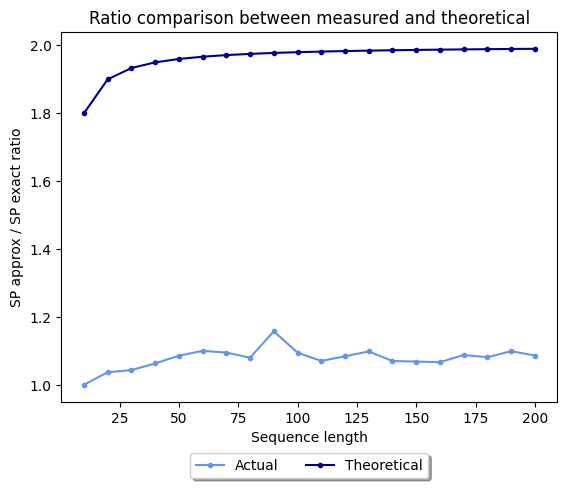

In [12]:
plt.plot(seq_len, ratio, color = 'cornflowerblue', marker = '.', label = 'Actual')
plt.plot(seq_len, theoretical_ratio, color = 'darkblue', marker = '.', label = 'Theoretical')
plt.xlabel('Sequence length')
plt.ylabel('SP approx / SP exact ratio')
plt.title('Ratio comparison between measured and theoretical')
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.12), fancybox = True, shadow = True, ncol = 2)
plt.show()

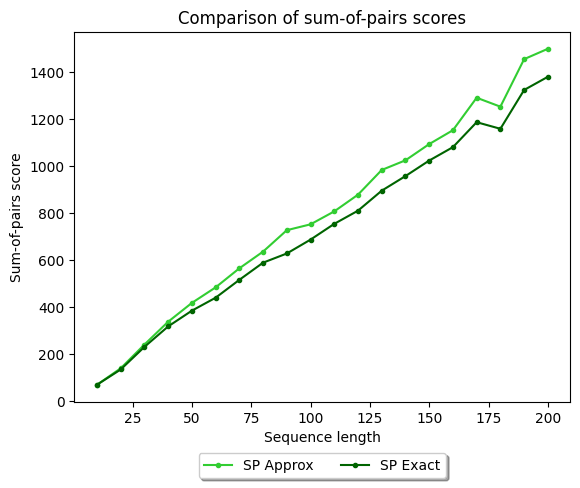

In [13]:
plt.plot(seq_len, SP_approx, color = 'limegreen', marker = '.', label = 'SP Approx')
plt.plot(seq_len, SP_exact, color = 'darkgreen', marker = '.', label = 'SP Exact')
plt.xlabel('Sequence length')
plt.ylabel('Sum-of-pairs score')
plt.title('Comparison of sum-of-pairs scores')
plt.grid(False)
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.12), fancybox = True, shadow = True, ncol = 2)
plt.show()

The first plot shows the scores achieved from running both algorithms on the 20 test files in the testseqs folder. The exact scores are lower than the approximate for every sequence length, as expected. The second plot shows the ratio between the two scores. Theoretically, the approximate score should be 4/3 times higher, but our testing only shows about 1.15. This is likely due to the (relatively short) length of the sequences. At very short sequence lengths, there is no difference between the approximate and exact score. As the lengths increase, the ratio between these two increases. Hence, with much greater sequence length the ratio could very likely approach the theoretical $2(k-1)/k$ for $k$ sequences.

## <span style='color:cornflowerblue'>Presentation<span/>


In [16]:
files = [file for file in os.listdir('brca1-full')]

file_names = sorted([file for file in files])
seq_len = [i for i in [3, 4, 5, 6, 'All']]
SP_approx = []

for file in file_names:
    approx_score = sp_approx(read_fasta(f'brca1-full/{file}'), scoreMatrix, gapCost)[1]
    SP_approx.append(approx_score)

In [17]:
data = {'File': file_names,
        'Seqs': seq_len,
        'SP_approx': SP_approx}

pd.DataFrame(data)

,File,Seqs,SP_approx
0,brca1-full-3.fasta,3,25762
1,brca1-full-4.fasta,4,61203
2,brca1-full-5.fasta,5,84829
3,brca1-full-6.fasta,6,113674
4,brca1-full.fasta,All,146866


Kernel dies for the exact algorithm.